# COVID-19 - ITALY - 2017-2019


## Initial setup and fetching data

In [68]:
import c19
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Fetch the Istat data
file_it_pop = 'data/Italy/italy_population_istat_2017-2019.csv'
pop = pd.read_csv(file_it_pop)


# Fetch COVID-19 data
url_c19 = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
c19df = pd.read_csv(url_c19)


## Pre-processing


In [69]:
# Preprocess the Istat dataset

# Replace Italian month names to corresponding numbers
pop['month'].replace(to_replace='Gennaio', value=1, inplace=True)
pop['month'].replace(to_replace='Febbraio', value=2, inplace=True)
pop['month'].replace(to_replace='Marzo', value=3, inplace=True)
pop['month'].replace(to_replace='Aprile', value=4, inplace=True)
pop['month'].replace(to_replace='Maggio', value=5, inplace=True)
pop['month'].replace(to_replace='Giugno', value=6, inplace=True)
pop['month'].replace(to_replace='Luglio', value=7, inplace=True)
pop['month'].replace(to_replace='Agosto', value=8, inplace=True)
pop['month'].replace(to_replace='Settembre', value=9, inplace=True)
pop['month'].replace(to_replace='Ottobre', value=10, inplace=True)
pop['month'].replace(to_replace='Novembre', value=11, inplace=True)
pop['month'].replace(to_replace='Dicembre', value=12, inplace=True)

# Create date as index
pop['date'] = pd.to_datetime(pop['year'].astype(str) + "-" + pop["month"].astype(str) + "-1")
pop.sort_values(by=['date'], inplace=True, ascending=True)
pop.set_index('date', inplace=True)

# Drop unused
pop.drop(columns=['territorial_variations','population_end', 'info'], inplace=True, errors="ignore")

In [88]:
pop.tail()


,year,month,population_start,births,deaths,sum_natural,registered,deleted,sum_migration
date,,,,,,,,,
2019-07-01,2019,7,60261833,39160,51507,-12347,149865,143336,6529
2019-08-01,2019,8,60256015,37953,49614,-11661,132524,123021,9503
2019-09-01,2019,9,60253857,38313,47267,-8954,145620,144111,1509
2019-10-01,2019,10,60246412,40917,52452,-11535,172516,163987,8529
2019-11-01,2019,11,60243406,35943,50865,-14922,152563,142525,10038


In [87]:
# Preprocess the COVID dataset

# Create a copy with the selected countries
c19_sel = c19df.loc[c19df['iso_code'].isin(['ITA'])].copy()

# Convert date column to datetime
c19_sel['date'] = pd.to_datetime(c19_sel['date'])

# Drop unused
c19_sel.drop(columns=['iso_code','location', 'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million', 
                      'new_deaths_per_million', 'tests_units'], inplace=True, errors="ignore")

# Fix NaN values
c19_sel['total_tests'].fillna(0, inplace=True)
c19_sel['new_tests'].fillna(0, inplace=True)
c19_sel['total_tests_per_thousand'].fillna(0, inplace=True)
c19_sel['new_tests_per_thousand'].fillna(0, inplace=True)

# sort by date and create index
c19_sel.sort_values(by=['date'], inplace=True, ascending=True)
c19_sel.set_index('date', inplace=True)


c19_sel.tail()



,total_cases,new_cases,total_deaths,new_deaths,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand
date,,,,,,,,
2020-04-25,192994,3021,25969,420,1707743.0,65387.0,28.245,1.081
2020-04-26,195351,2357,26384,415,1757659.0,49916.0,29.071,0.826
2020-04-27,197675,2324,26644,260,1789662.0,32003.0,29.600,0.529
2020-04-28,199414,1739,26977,333,1846934.0,57272.0,30.547,0.947
2020-04-29,201505,2091,27359,382,1910761.0,63827.0,31.603,1.056


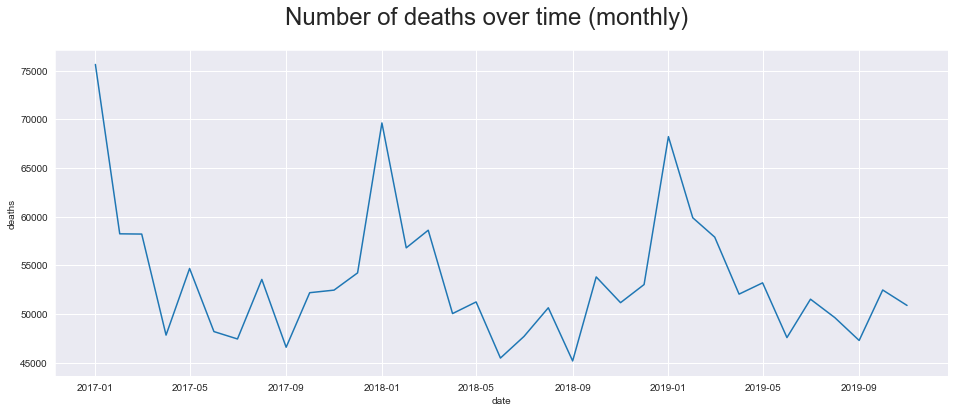

In [89]:
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, figsize=(16, 6))
fig.suptitle('Number of deaths over time (monthly)', fontsize=24)

ax = axes
ax.grid(b=True, which='major', color='w', linewidth=1.0)

sns.lineplot(x=pop.index, y="deaths", data=pop, ax=ax)


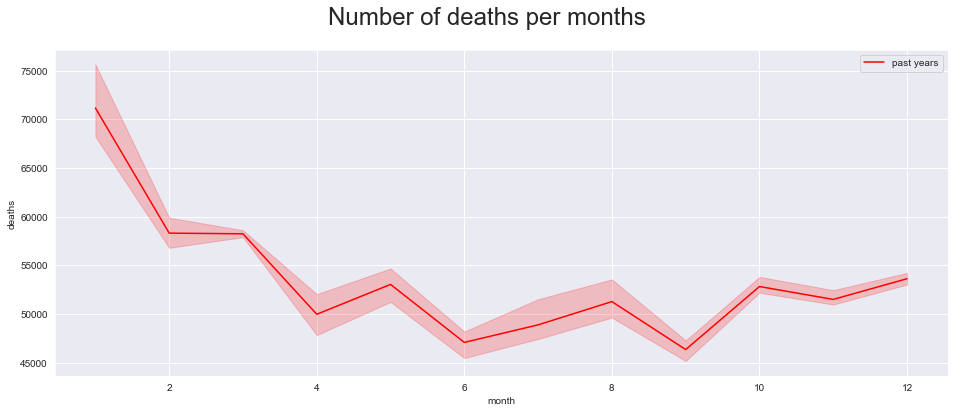

In [90]:
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, figsize=(16, 6))
fig.suptitle('Number of deaths per months', fontsize=24)

ax = axes
ax.grid(b=True, which='major', color='w', linewidth=1.0)

sns.lineplot(x='month', y="deaths", markers=True, color="red", label="past years", data=pop, ax=ax)


